In [102]:
import pandas as pd
import numpy as np
import tensorflow as tf
from data_loader import load_veterans_ds, prepare_veterans_ds
from sklearn.preprocessing import StandardScaler
from utility import InputFunction, CindexMetric, CoxPHLoss, _make_riskset, _TFColor, sample_hmc
import matplotlib.pyplot as plt
import seaborn as sns

TFColor = _TFColor()
dtype = tf.float32

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

# Convert to arrays
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test =  np.array(X_test)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [18]:
import os
from pathlib import Path

"""
n_dims = 1

curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent.parent.parent
df = pd.read_csv(Path().joinpath(root_dir, "downloads/AustinCats.csv"))

df['black'] = df.color.apply(lambda x: x=='Black')
df['adopted'] = df.out_event.apply(lambda x: x=='Adoption')

x_cens = tf.convert_to_tensor(df.query('adopted==0').black.values, dtype=dtype)
x_obs = tf.convert_to_tensor(df.query('adopted==1').black.values, dtype=dtype)

y_cens = tf.convert_to_tensor(df.query('adopted==0').days_to_event, dtype=dtype)
y_obs = tf.convert_to_tensor(df.query('adopted==1').days_to_event, dtype=dtype)

x_obs = tf.reshape(x_obs, (-1, n_dims))
x_cens = tf.reshape(x_cens, (-1, n_dims))
"""

'\nn_dims = 1\n\ncurr_dir = os.getcwd()\nroot_dir = Path(curr_dir).absolute().parent.parent.parent\ndf = pd.read_csv(Path().joinpath(root_dir, "downloads/AustinCats.csv"))\n\ndf[\'black\'] = df.color.apply(lambda x: x==\'Black\')\ndf[\'adopted\'] = df.out_event.apply(lambda x: x==\'Adoption\')\n\nx_cens = tf.convert_to_tensor(df.query(\'adopted==0\').black.values, dtype=dtype)\nx_obs = tf.convert_to_tensor(df.query(\'adopted==1\').black.values, dtype=dtype)\n\ny_cens = tf.convert_to_tensor(df.query(\'adopted==0\').days_to_event, dtype=dtype)\ny_obs = tf.convert_to_tensor(df.query(\'adopted==1\').days_to_event, dtype=dtype)\n\nx_obs = tf.reshape(x_obs, (-1, n_dims))\nx_cens = tf.reshape(x_cens, (-1, n_dims))\n'

In [150]:
# Prepare data
n_dims = 1

y_obs = tf.convert_to_tensor(t_train[e_train], dtype=dtype)
y_cens = tf.convert_to_tensor(t_train[~e_train], dtype=dtype)

x_obs = tf.convert_to_tensor(X_train[e_train][:,1], dtype=dtype)
x_cens = tf.convert_to_tensor(X_train[~e_train][:,1], dtype=dtype)

#x_obs = tf.reshape(x_obs, (-1, n_dims))
#x_cens = tf.reshape(x_cens, (-1, n_dims))

In [151]:
obs_model = tfd.JointDistributionSequentialAutoBatched([
        tfd.Normal(loc=3, scale=3), # alpha
        tfd.Normal(loc=0, scale=3), # beta
        lambda beta, alpha: tfd.Exponential(rate=1/tf.math.exp(x_obs*beta + alpha))]
    )

def log_prob(x_obs, x_cens, y_obs, y_cens, alpha, beta):
    lp = obs_model.log_prob([alpha, beta, y_obs])
    potential = exponential_lccdf(x_cens, y_cens, alpha, beta)
    return lp + potential

def exponential_lccdf(x_cens, y_cens, alpha, beta):
    return tf.reduce_sum(-y_cens / tf.exp(x_cens*beta + alpha))

In [105]:
"""
bias_size = [1]
coeffs_size = [n_dims, 1]
number_of_steps = 1000
number_burnin_steps = 1000
n_chains = 1
initial_coeffs = obs_model.sample(n_chains)
"""

'\nbias_size = [1]\ncoeffs_size = [n_dims, 1]\nnumber_of_steps = 1000\nnumber_burnin_steps = 1000\nn_chains = 1\ninitial_coeffs = obs_model.sample(n_chains)\n'

In [152]:
"""
bias_size = [1]
coeffs_size = [n_dims, 1]
initial_states = [tf.zeros(bias_size, name='init_alpha'),
                  tf.zeros(coeffs_size, name='init_coeffs')]
"""
number_of_steps = 1000
number_burnin_steps = 1000

n_chains = 1
initial_coeffs = obs_model.sample(n_chains)
unnormalized_post_log_prob = lambda *args: log_prob(x_obs, x_cens, y_obs, y_cens, *args)

samples = sample_hmc(unnormalized_post_log_prob, [tf.zeros_like(initial_coeffs[0]),
                                                  tf.zeros_like(initial_coeffs[1])],
                     n_steps=number_of_steps, n_burnin_steps=number_burnin_steps)

In [153]:
# Save alpha and betas
alphas = samples[0].numpy().flatten()
betas = np.zeros((n_dims, number_of_steps))

for i in range(n_dims):
    betas[i] = samples[1][:,i].numpy().flatten()
    
print(alphas.mean())
print(betas.mean())

4.81413
0.3826536442004144


Text(0, 0.5, 'Density')

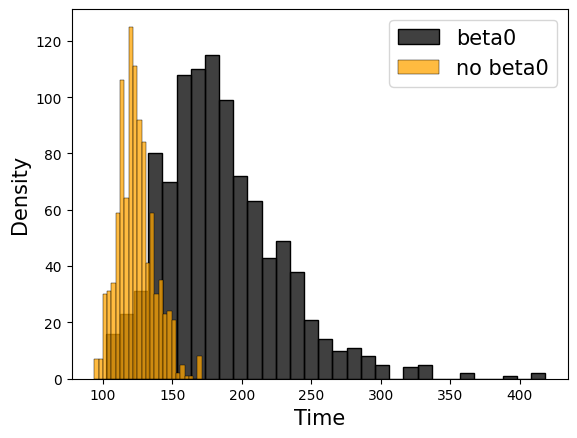

In [154]:
lambda_feature = np.exp(alphas + betas[0])
lambda_no_feature = np.exp(alphas)

sns.histplot(lambda_feature,color='k',label='beta0')
sns.histplot(lambda_no_feature,color='orange',label='no beta0')
plt.legend(fontsize=15)
plt.xlabel("Time",size=15)
plt.ylabel("Density",size=15)

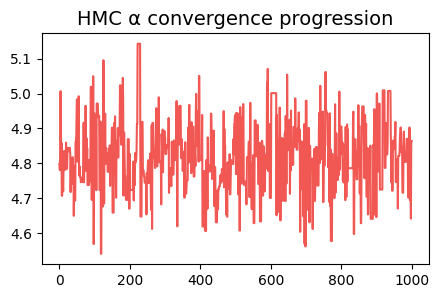

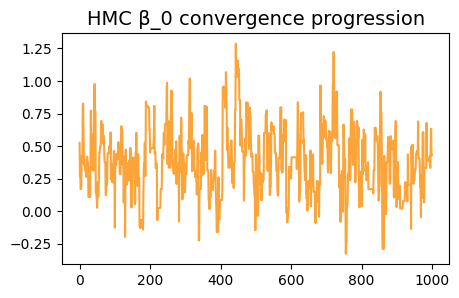

In [155]:
# plotting the Posterior Samples
plt.figure(figsize=(5,3))
plt.plot(np.arange(number_of_steps), alphas, color=TFColor[0])
plt.title('HMC α convergence progression', fontsize=14)

for i in range(betas.shape[0]):
    plt.figure(figsize=(5,3))
    plt.plot(np.arange(number_of_steps), betas[i], color=TFColor[1])
    plt.title(f'HMC β_{i} convergence progression', fontsize=14)
    plt.show()

Text(0.5, 1.0, 'KDE plot for β samples')

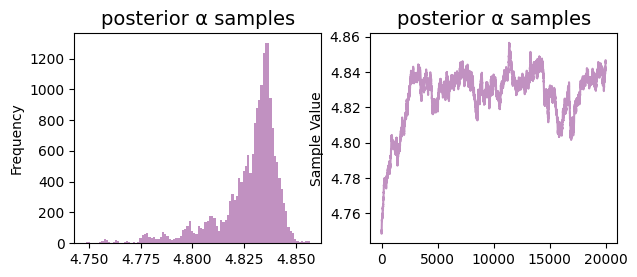

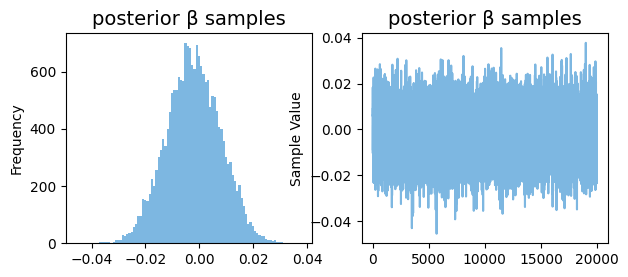

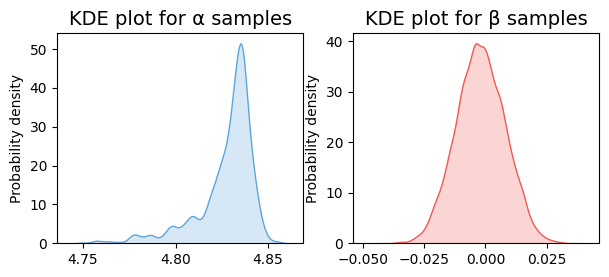

In [68]:
# plotting the Posterior Samples
import seaborn as sns

#alpha (α)
#beta (β)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(alphas, bins=100, color=TFColor[6], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior α samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), alphas, color=TFColor[6], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior α samples', fontsize=14)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(betas[0], bins=100, color=TFColor[3], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior β samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), betas[0], color=TFColor[3], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior β samples', fontsize=14)

#KDE Plots
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
ax2 = sns.kdeplot(alphas, fill=True, color=TFColor[3], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for α samples', fontsize=14)

plt.subplot(2, 2, 2)
ax1 = sns.kdeplot(betas[0], fill=True, color=TFColor[0], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for β samples', fontsize=14)

In [67]:
# Set number of chains.
num_chains = 4
# Run sampling.
chains = [sample_hmc(unnormalized_post_log_prob, initial_states,
                     n_steps=number_of_steps, n_burnin_steps=number_burnin_steps) for i in range(num_chains)]

In [68]:
chains_t = list(map(list, zip(*chains)))
chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

In [69]:
chains_samples

[<tf.Tensor: shape=(80000,), dtype=float32, numpy=
 array([3.0692892, 3.0692892, 3.0692892, ..., 4.697585 , 4.697585 ,
        4.697585 ], dtype=float32)>,
 <tf.Tensor: shape=(80000, 8), dtype=float32, numpy=
 array([[ 1.9925971e-02,  2.2884475e-01,  2.2006062e-01, ...,
          1.4480146e-03,  5.9338141e-02,  4.4749480e-02],
        [ 1.9925971e-02,  2.2884475e-01,  2.2006062e-01, ...,
          1.4480146e-03,  5.9338141e-02,  4.4749480e-02],
        [ 1.9925971e-02,  2.2884475e-01,  2.2006062e-01, ...,
          1.4480146e-03,  5.9338141e-02,  4.4749480e-02],
        ...,
        [ 2.9350158e-05,  7.1442790e-02,  7.6402977e-02, ...,
          6.0717890e-04, -3.1759996e-02,  2.6993744e-02],
        [ 2.9350158e-05,  7.1442790e-02,  7.6402977e-02, ...,
          6.0717890e-04, -3.1759996e-02,  2.6993744e-02],
        [ 2.9350158e-05,  7.1442790e-02,  7.6402977e-02, ...,
          6.0717890e-04, -3.1759996e-02,  2.6993744e-02]], dtype=float32)>]

In [75]:
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['alpha'] + [f'beta_{i}' for i in range(n_dims)]
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % number_of_steps,
        chain_id=lambda x: (x['sample_id'] / number_of_steps).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

,alpha,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,sample_id,chain_sample_id,chain_id
0,3.069289,0.019926,0.228845,0.220061,0.235287,0.006235,0.001448,0.059338,0.044749,0,0,c_1
1,3.069289,0.019926,0.228845,0.220061,0.235287,0.006235,0.001448,0.059338,0.044749,1,1,c_1
2,3.069289,0.019926,0.228845,0.220061,0.235287,0.006235,0.001448,0.059338,0.044749,2,2,c_1
3,3.069289,0.019926,0.228845,0.220061,0.235287,0.006235,0.001448,0.059338,0.044749,3,3,c_1
4,3.069289,0.019926,0.228845,0.220061,0.235287,0.006235,0.001448,0.059338,0.044749,4,4,c_1


Text(0.5, 1.03, 'Posterior Samples per Chain')

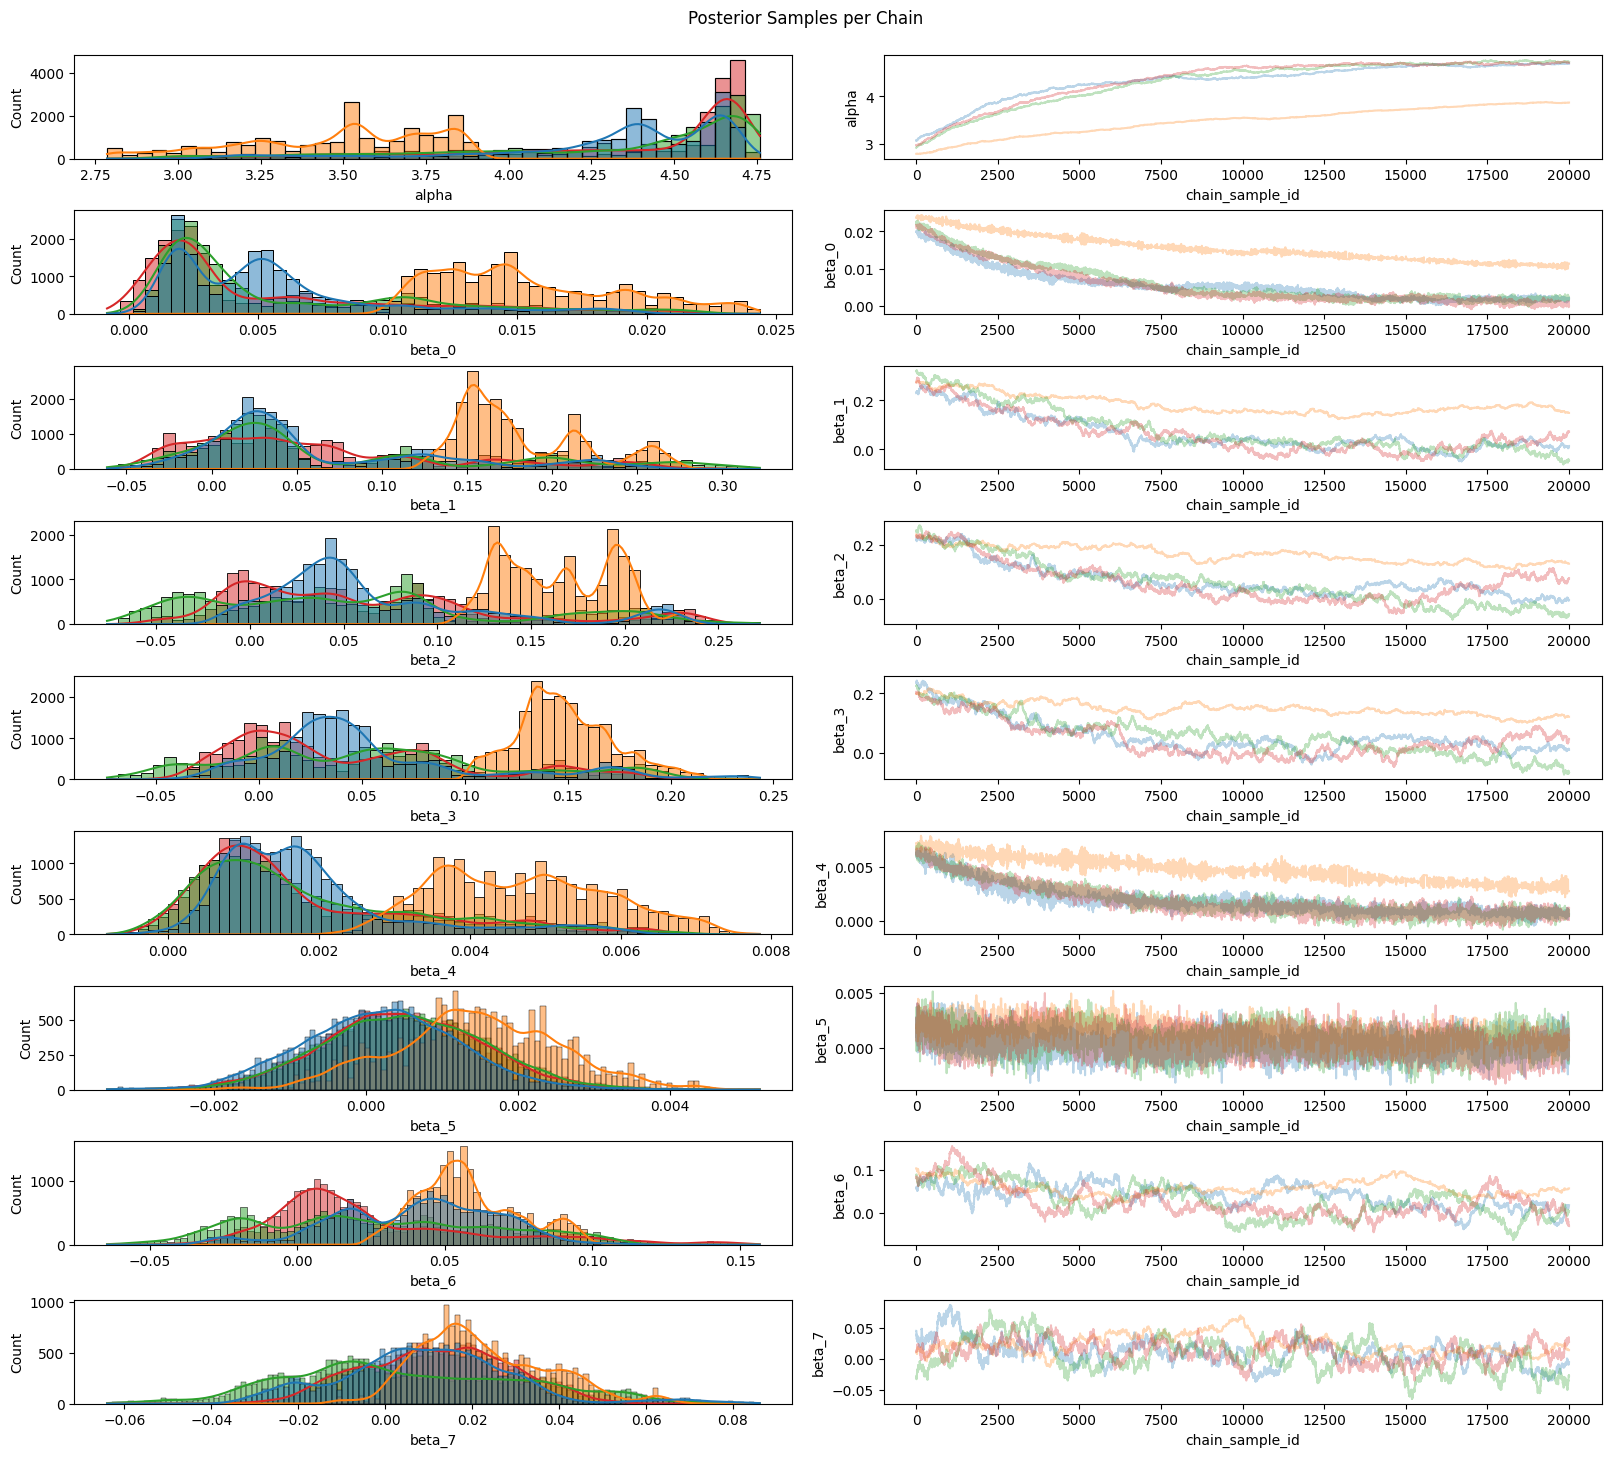

In [85]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(16, 14), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0], legend=False)
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03)

Text(0.5, 1.03, 'Posterior Samples')

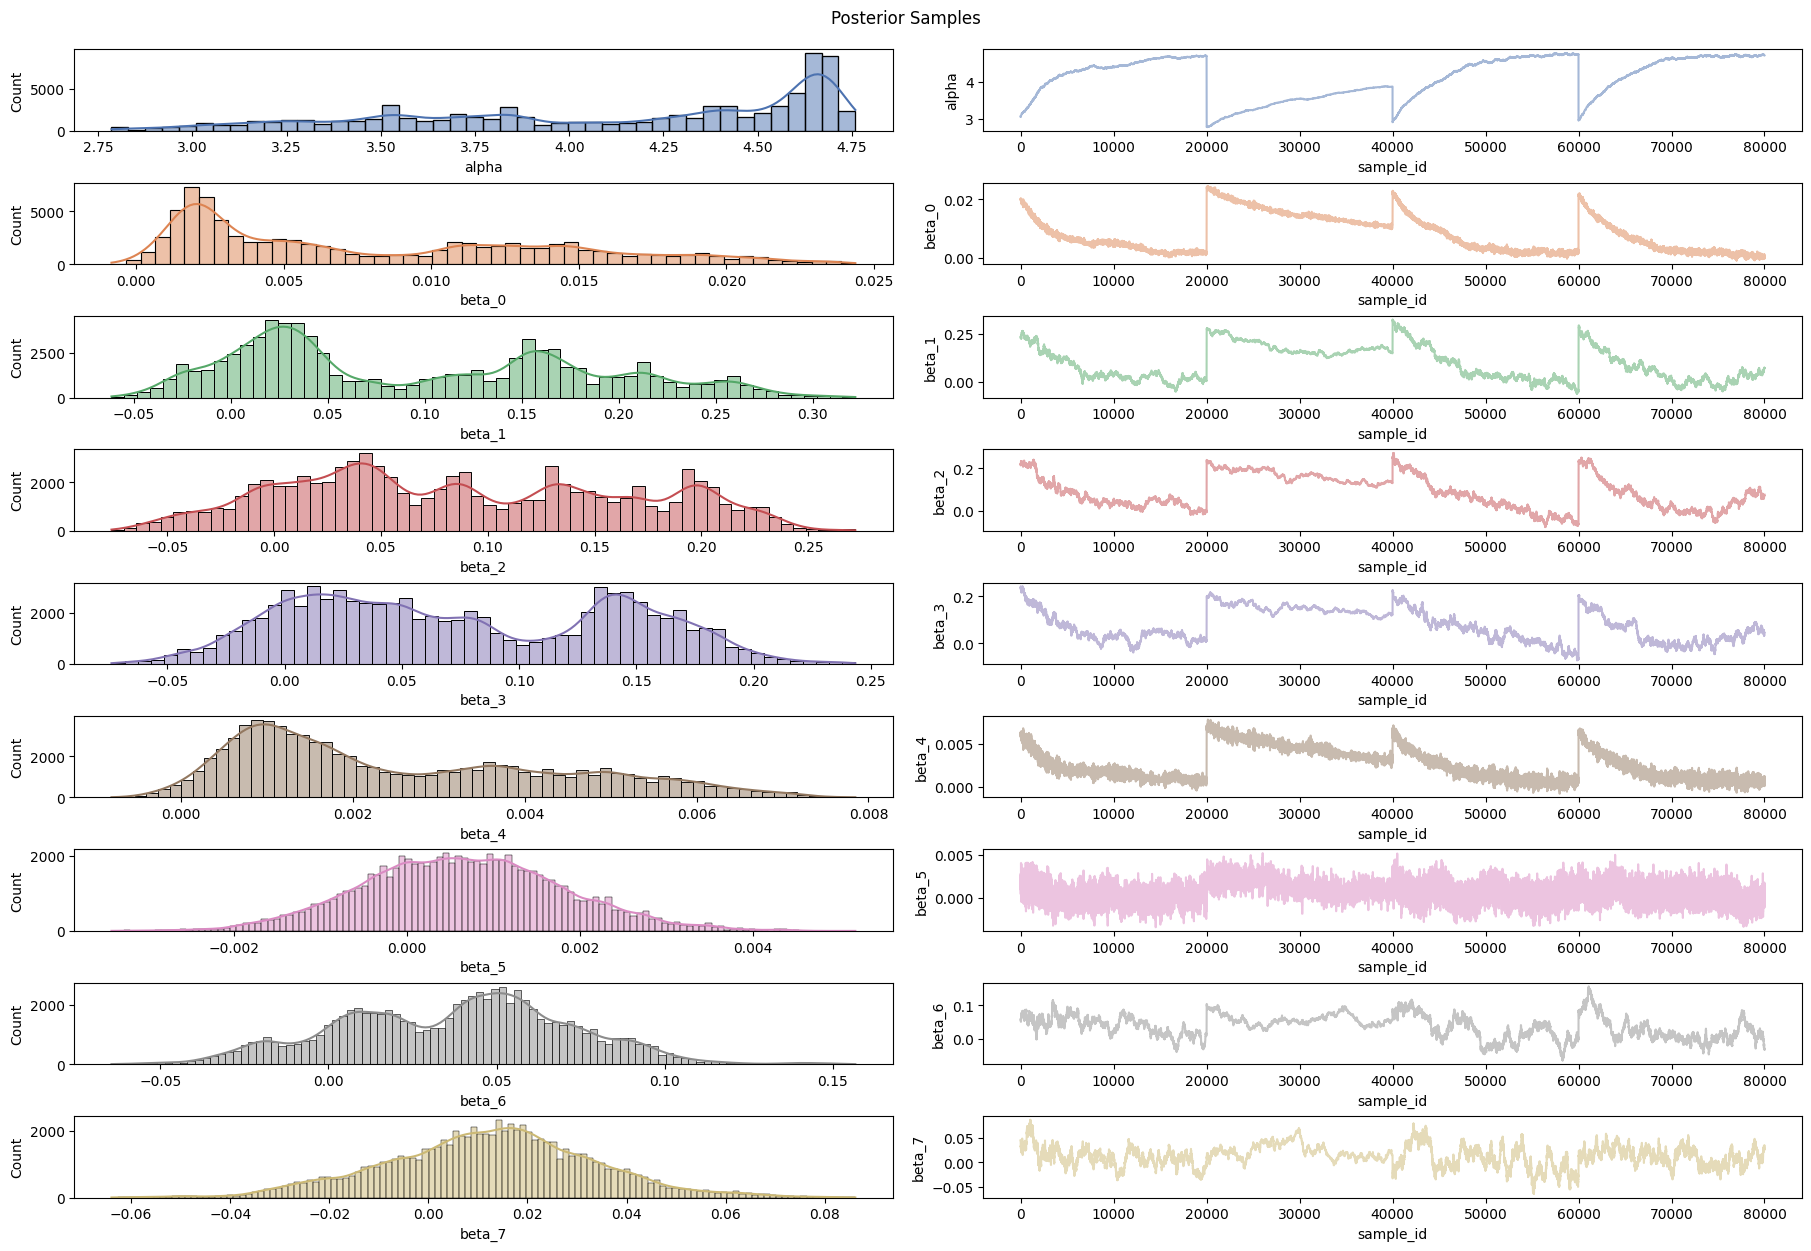

In [86]:
sns_c = sns.color_palette(palette='deep')

fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(18, 12), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, color=sns_c[i], kde=True, ax=axes[i][0])
    sns.lineplot(x='sample_id', y=param, data=chains_df, color=sns_c[i], alpha=0.5, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03)

In [93]:
# Make predictions on valid dataset
x_valid_obs = tf.convert_to_tensor(X_valid[:,:n_dims], dtype=dtype)

mean_alpha = tf.math.reduce_mean(alphas, axis=0).numpy()
mean_beta = tf.math.reduce_mean(betas, axis=0).numpy()

def predict_lambda(alpha, beta, data):
    return np.exp(alpha + beta*data)

y_preds = np.zeros((len(x_valid_obs)))
for i, data in enumerate(x_valid_obs):
    y_preds[i] = predict_lambda(mean_alpha, mean_beta, data)

In [94]:
y_preds

array([293.21279907, 175.22317505, 202.99006653, 293.21279907,
       365.60137939,  25.88866234,  58.13896942, 202.99006653,
       235.15707397, 188.59631348, 315.5909729 , 202.99006653,
       253.10440063, 253.10440063])

In [77]:
y_valid

array([( True, 110.), ( True,   8.), ( True, 153.), ( True, 392.),
       ( True,  80.), ( True,   1.), ( True, 117.), ( True,  12.),
       ( True,  31.), ( True, 389.), ( True, 151.), ( True,  54.),
       ( True,   8.), ( True, 177.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [185]:
size = 100
x0 = np.random.randn(size)
x1 = np.random.randn(size)
x = np.stack([x0], axis=1)
x = tf.convert_to_tensor(x, dtype=dtype)

In [236]:
# Here we compute mu = alpha + beta x. #TODO: Needs to fit surv analysis exp(alpha +beta*x)
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[0], (-1, 1)), tf.ones(shape=(1, x_obs.shape[0]))) \
    + tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.transpose(x_obs))

In [237]:
mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()

In [245]:
tf.squeeze(y_obs).numpy()

array([ 53.,  42., 228., 162.,  61.,  36.,  18.,  24., 242.,  10.,  18.,
       340., 103.,  25.,  30.,  29.,  54., 378., 200., 126.,   3.,  24.,
       216.,  82.,   1., 231.,  51., 186.,  52.,  31., 100.,  99.,  51.,
       140.,   8., 111.,  87.,   7.,  20., 411.,  21.,  80.,  63., 118.,
         4., 122.,  10.,  95.,  43., 201.,  72.,  52.,  56., 162., 111.,
       287.,  59., 991., 139.,   7., 553.,  90.,  45.,  20.,  84.,  11.,
        99.,  13.,  21., 132.,   7.,   8., 467., 143.,  49.,  33., 999.,
        25., 133., 587.,  16.,  51., 357., 164.,  92.,  15.,  27.,  25.,
       105., 278., 144.,  19.,  15., 112., 283.,  18.,  95., 250.,  48.,
        35.], dtype=float32)

In [120]:
alphas = alphas.numpy().flatten()
beta_0 = betas[:,0,:].numpy().flatten()
beta_1 = betas[:,1,:].numpy().flatten()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

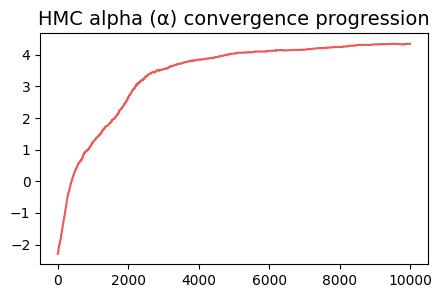

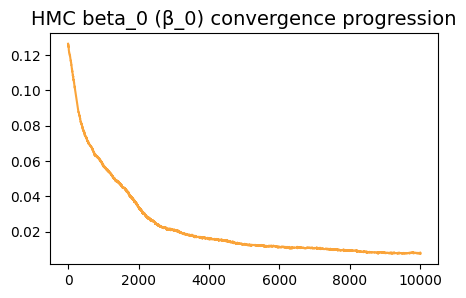

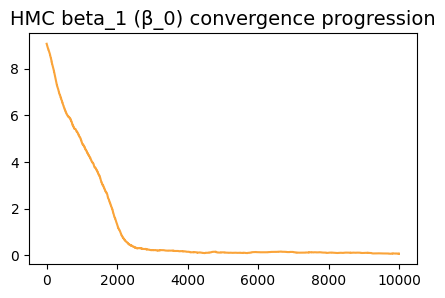

In [109]:
# plotting the Posterior Samples
plt.figure(figsize=(5,3))
plt.plot(np.arange(number_of_steps), alphas, color=TFColor[0])
plt.title('HMC alpha (α) convergence progression', fontsize=14)

plt.figure(figsize=(5,3))
plt.plot(np.arange(number_of_steps), beta_0, color=TFColor[1])
plt.title('HMC beta_0 (β_0) convergence progression', fontsize=14)

plt.figure(figsize=(5,3))
plt.plot(np.arange(number_of_steps), beta_1, color=TFColor[1])
plt.title('HMC beta_1 (β_0) convergence progression', fontsize=14)
plt.show()

Text(0.5, 1.0, 'KDE plot for beta_1 (β_1) samples')

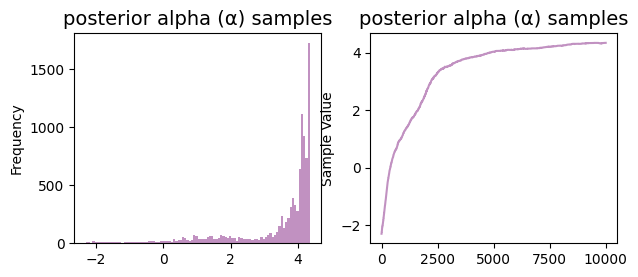

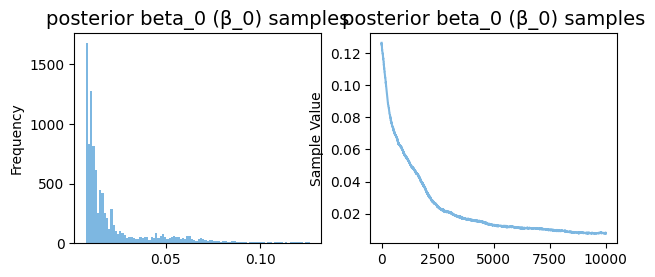

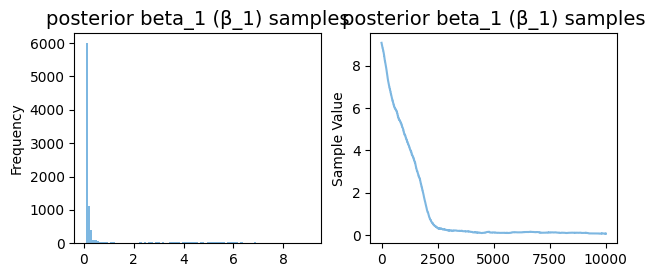

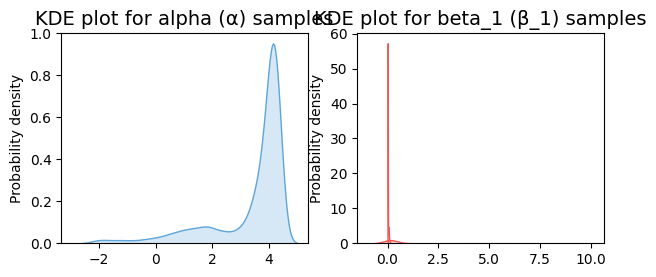

In [113]:
# plotting the Posterior Samples
import seaborn as sns

#alpha (α)
#beta (β)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(alphas, bins=100, color=TFColor[6], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior alpha (α) samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), alphas, color=TFColor[6], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior alpha (α) samples', fontsize=14)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(beta_0, bins=100, color=TFColor[3], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior beta_0 (β_0) samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), beta_0, color=TFColor[3], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior beta_0 (β_0) samples', fontsize=14)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(beta_1, bins=100, color=TFColor[3], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior beta_1 (β_1) samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), beta_1, color=TFColor[3], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior beta_1 (β_1) samples', fontsize=14)

#KDE Plots
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
ax2 = sns.kdeplot(alphas, fill=True, color=TFColor[3], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for alpha (α) samples', fontsize=14)

plt.subplot(2, 2, 2)
ax1 = sns.kdeplot(beta_0, fill=True, color=TFColor[0], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for beta_0 (β_0) samples', fontsize=14)

plt.subplot(2, 2, 2)
ax1 = sns.kdeplot(beta_1, fill=True, color=TFColor[0], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for beta_1 (β_1) samples', fontsize=14)

In [318]:
alphas = alphas.numpy().flatten()
betas = betas.numpy().flatten()

In [332]:
predict_func = lambda data: alphas + betas * data
x_train_data = X_train[:,0]

y_preds = np.zeros((len(x_train_data)))
for i, signal in enumerate(x_train_data):
    y_preds[i] = predict_func(signal).mean()

In [320]:
random_guess = tf.convert_to_tensor(np.random.uniform(0, 10, size=(len(y_preds), 1)).astype(np.float32))

In [337]:
train_event_set = tf.expand_dims(e_train.astype(np.int32), axis=1)
train_risks_set = tf.convert_to_tensor(_make_riskset(t_train))
y_pred = tf.convert_to_tensor(y_preds.reshape(len(y_preds), 1).astype(np.float32))

In [339]:
mcmc_train_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=y_pred)
random_guess_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=random_guess)
print(f"MCMC loss {mcmc_train_loss}, random: {random_guess_loss}")

MCMC loss 3.4211440086364746, random: 5.77722692489624
